# Configure

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
from os.path import join

os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Filepath directories

# Get the absolute path to the project directory
# Which is one directory above notebooks/
ABS_DIR = os.path.abspath(Path(os.getcwd()).parents[0])
# Get raw data directory
FR = join(ABS_DIR, 'data', 'raw')
# Get interim data directory
FI = join(ABS_DIR, 'data', 'interim')
# Get processed data directory
FP = join(ABS_DIR, 'data', 'results')

# Directories for interim exposure, vulnerability (vuln) and 
# hazard
EXP_DIR_I = join(FI, 'exposure')
VULN_DIR_I = join(FI, 'vuln')
HAZ_DIR_I = join(FI, 'haz')
REF_DIR_I = join(FI, 'ref')

# Ensure they exist
Path(EXP_DIR_I).mkdir(parents=True, exist_ok=True)
Path(VULN_DIR_I).mkdir(parents=True, exist_ok=True)
Path(HAZ_DIR_I).mkdir(parents=True, exist_ok=True)
Path(REF_DIR_I).mkdir(parents=True, exist_ok=True)

# Prepare our results directory
Path(FP).mkdir(parents=True, exist_ok=True)

# Reference fips
FIPS = '42101'

# Prepare structure data for loss ensemble

## Load and subset exposure data

In [4]:
# Load nsi_res.gpkg, nsi_ref.pqt, and nsi_depths.pqt
nsi_struct = gpd.read_file(join(EXP_DIR_I, 'nsi_res.gpkg'))
nsi_ref = pd.read_parquet(join(EXP_DIR_I, 'nsi_ref.pqt'))
nsi_depths = pd.read_parquet(join(EXP_DIR_I, 'nsi_depths.pqt'))
# Also load the nsi_fz.pqt file because we need to know A or V fz
# for using the hazus ddfs
nsi_fz = pd.read_parquet(join(EXP_DIR_I, 'nsi_fz.pqt'))

In [5]:
# Need foundation type, number stories, structure value
# for our ensemble. Structure value will be the center of 
# the distribution and will be passed to the loss estimation
# function. Foundation type will be drawn from the implicit
# distribution in the NSI data. For each census block, 
# we are going to get the multinomial probabilities of 
# a building having a certain foundation type & number of stories
# Ideally, we would do this conditioned on prefirm but the
# building year column is based on median year built from ACS
# data
# From the foundation type that is drawn from the multinomial in 
# the ensemble, we will get the FFE from the distribution 
# defined in the code for the Wing et al. 2022 paper
# The point estimate version will just use default values

# Start by retaining only relevant columns in nsi_struct
# Then subset this and nsi_ref to the fd_id in nsi_depths
keep_cols = ['fd_id', 'occtype', 'found_type', 'val_struct']
nsi_res = nsi_struct[keep_cols]

# Let's merge in refs into nsi_res
nsi_res = nsi_res.merge(nsi_ref, on='fd_id')

# We're also going to merge in fzs
nsi_res = nsi_res.merge(nsi_fz[['fd_id', 'fld_zone']], on='fd_id')

# Split occtype to get the number of stories and basement
# We only need to keep stories for the purposes
# of estimating the distribution that stories comes from
# We will draw basement from the foundation type
# distribution which also gives us first floor elevation
structs = nsi_res['occtype'].str.split('-').str[1]
basements = structs.str[2:]
stories = structs.str[:2]

nsi_res = nsi_res.assign(stories=stories)

# Retain only the rows that correspond to structures
# that are exposed to flood depths
nsi_res_f = nsi_res[nsi_res['fd_id'].isin(nsi_depths['fd_id'])]

# Merge in the depths to the struct df you are working with
# Also merge in the refs - there are inconsistencies
# with the cbfips column from nsi directly and the
# block data I downloaded from the census webpage
# You retain more structures if you use the block data 
full_df = nsi_res_f.merge(nsi_depths, on='fd_id')

# This dataset can be directly used for estimating the 
# benchmark losses of using NSI as-is
# Use the Hazus DDFs with no uncertainty

In [6]:
# Let's get the fld_zone column processed for the way it needs
# to be done for using hazus ddfs
# Get the first character of the flood zone and only retain it
# if it's a V zone. We are going to use A zone for A and outside
# (if any) flood zone depth exposures
ve_zone = np.where(full_df['fld_zone'].str[0] == 'V',
                   'V',
                   'A')
full_df = full_df.assign(fz_ddf = ve_zone)

In [7]:
# Finally, following the heuristic used in the Philadelphia
# hazard mitigation plan for estimating flood losses,
# we'll take the max of the Inl and Cst depths for the same RP
# to get one value for a RP

# First subset to depth columns, keep id in there
depth_cols = full_df.columns[full_df.columns.str.contains('Inl|Cst')]
depth_df = full_df[list(depth_cols) + ['fd_id']].melt(id_vars='fd_id',
                                                      value_name='depth')
# Get the two fld types and return period
depth_df['fld_type'] = depth_df['variable'].str.split('_').str[0]
depth_df['ret_per'] = depth_df['variable'].str.split('_').str[1]
# This is giving us a data frame with the depths for flood types
# in each return period side by side
# We will take the max value of these to represent the depth
# for that particular return period
depth_df_f = depth_df.pivot(index=['fd_id','ret_per'], columns='fld_type',
                            values='depth')
depth_df_f['depth'] = np.max(depth_df_f[['Cst', 'Inl']], axis=1)

# Now we will get the dataframe with fd_id and depths under different
# return periods
depths_merge = depth_df_f.reset_index().drop(columns=['Cst', 'Inl'])
depths_merge = depths_merge.pivot(index='fd_id', columns='ret_per')

# We will modify the column names to have depth_rp
# for easier identification later
depths_merge.columns = [x[0] + '_' + x[1] for x in depths_merge.columns]

# And we will merge this back in to full_df
# Drop the depth_cols
full_df = full_df.drop(columns=depth_cols)
# We reset index on depths_merge so we can merge on fd_id
full_df = full_df.merge(depths_merge.reset_index(), on='fd_id')

## Get parameters for structure uncertainty distributions

In [8]:
# We are also going to use nsi_struct merged with refs
# to determine the multinomial probabilities of basement
# and number stories (binomial) from block level which matches
# up with NSI tech reference on where data is randomly assigned
# from. While there are maps from parcel data, where available, 
# it's not clear which entries have this non-random assignment. 
# In addition, it is known that parcel aggregation datasets like
# ZTRAX may have data errors. The sources the NSI used
# have unknown validation/accuracy so we can treat these as
# part of estimating the distribution to draw from

# The method for estimating number of stories is based on assignment
# from parcel data. Where missing, square footage is divided by the 
# structure's footprint (when sq. ft. is missing, they take 86% of
# the structure's footprint as sq. ft). If > 1.25,
# a second floor is assumed
# If no footprint is available, 
# stories is randomly assigned from a distribution that varies by
# year built and census region. So, we can use census block again
# here

# The methodology for the structure valuation is obscure
# and there is no reporting on how accurate it is to some
# observed data on market values
# In a conservative thrust, we can take the reported
# coefficient of determination from Philadelphia Assesor's 
# methodology for estimating market values. This COD can be
# multiplied by the estimated value from NSI for a presumably
# conservative estimate of the standard deviation surrounding
# structure value estimates to observed market values
# We can also show in a representative example what would
# happen to the loss estimate distribution
# if the NSI COD is a factor of 2 larger. We still don't know
# if this is a reasonable representation since we assume
# there is no bias in the NSI structure valuation by
# centering the noise distribution at their estimated value. 
# In reality, the Philly assessor office reports their estimates
# are slightly biased which allows us to use a bias correction
# factor if we used that data. Down the line, comparing
# what the structure inventory distributions are using different
# data sources could be very interesting, including accounting
# for different # of RES1 buildings based on more detailed
# and survye-based methods in the city assessor data
# From the Nolte et al. (2023) large-scale parcel data good
# practices data, we know that there are many issues in using parcel
# data to fill in important data fields (even occupancy type)
# It is not the panacea it appears framed as in the NSI technical
# documentation

# There are not nearly enough observations at the block level
# to reliably estimate the parameter for binomial # stories
# or multinomial foundation type. Sometimes just one observation
# in general. Block group appears to have enough
# This check is based on the subset of block groups (or other ref)
# in nsi_res that are also in full_df (these are the ones) we need
# the probabilities for
struct_tot = nsi_res[nsi_res['bg_id'].isin(full_df['bg_id'])]

### Number of stories

In [9]:
# Get the total number of structures w/ number of stories 
# in each block gruop
stories_sum = struct_tot.groupby(['bg_id', 'stories']).size()
# Then get the proportion
stories_prop = stories_sum/struct_tot.groupby(['bg_id']).size()
# Our parameters can be drawn from this table based on the bg_id
# of a structure we are estimating losses for
stories_param = stories_prop.reset_index().pivot(index='bg_id',
                                                 columns='stories',
                                                 values=0).fillna(0)
# Since it's a binomial distribution, we only need to specify
# one param. Arbitrarily choose 1S
# Round the param to the hundredth place
# Store in a dict
stories_param = stories_param['1S'].round(2)
STRY_DICT = dict(stories_param)

### Foundation type

In [10]:
# Repeat procedure above
found_sum = struct_tot.groupby(['bg_id', 'found_type']).size()
found_prop = found_sum/struct_tot.groupby(['bg_id']).size()
found_param = found_prop.reset_index().pivot(index='bg_id',
                                             columns='found_type',
                                             values=0).fillna(0)

# We want a dictionary of bg_id to a list of B, C, S
# for direct use in our multinomial distribution draw
# Store params in a list (each row is bg_id and corresponds to
# its own probabilities of each foundation type)
params = found_param.values.round(2)
# Then create our dictionary
FND_DICT = dict(zip(found_param.index, params))


### Constants

In [11]:
# Coefficient of determination for structure value
# https://www.phila.gov/media/20220525080608/
# tax-year-2023-mass-appraisal-valuation-methodology.pdf
# There are three types of single family homes in Philadelphia
# Their coefficient of dispersions are
# Row: .134
# Singles: .113
# Twins: .107
# Taking the weighted average of these (41080, 3584, 9188)
# from the sample sizes of their methodology, we get
# a coefficient of determination of .12799
# So let's use .128
CF_DET = .128

# Triangular distributions for first-floor elevation conditioned
# on foundation type
# Can store these parameters in dictionaries

# From this repo: https://github.com/HenryGeorgist/go-fathom/
# blob/master/compute/foundationheights.go
# from the wing et al. 2022 paper
# distributions (min, most likely, max) conditioned on foundation type
# Tri(0, .5, 1.5|Slab)
# Tri(0, 1.5, 4|Crawl)
# Tri(0, 1.5, 4|Basement)
# Tri(6, 9, 12|Pier)
# Tri (6, 9, 12|Pile)
# For this case study, only need 'S', 'C', and 'B'

FFE_DICT = {'S': [0, .5, 1.5],
            'C': [0, 1.5, 4],
            'B': [0, 1.5, 4]}

# After you get the series of foundation types for
# each house, you can generate random FFE values
# from FFE_DICT[fnd_type] 
# using np.random.default_rng().triangular
# Because this is conditional on fnd_type, I think
# we can call .loc[fnd_type == ft] for each ft in fnd_type
# and generate random draws that is the length of that
# subset and get fd_id/ffe pairs as a dict (ffe_map). 
# After looping through the fnd_types, we can do .map(ffe_map)
# We will have to merge dictionaries using x = x | y
# https://stackoverflow.com/questions/38987/
# how-do-i-merge-two-dictionaries-in-a-single-expression-in-python
# which we can do after each loop where y is the newly
# created loop for a specific fnd_type subset

# Load and prepare DDFs

In [12]:
# Need to load in DDFs and make sure they are in the correct form
# for drawing pct_dam from a probabilistic distribution
# Separate these versions from the point estimate based one

# We need bld_type (i.e. 1SWB) dict to param combos
# So for NACCS DDFs, we want 1SWB: [min, most likely, max] to
# input to the triangular distribution
# For Hazus, we want 1SWB_A (also V and w/ NB no fld zone): 
# [max(0, est-.3), min(1, est+.3)] to input to a uniform distribution

# Each bld_type key will map to a dict of depth: params
# pairs

# Read files
naccs = pd.read_csv(join(VULN_DIR_I, 'physical', 'naccs_ddfs.csv'))
hazus = pd.read_csv(join(VULN_DIR_I, 'physical', 'hazus_ddfs.csv'))

In [13]:
# NACCS Processing

# Add bld_type (i.e. 1SWB) column
bld_type = naccs['occtype'].str.split('-').str[1]
naccs = naccs.assign(bld_type = bld_type)

# Subset to RES1
naccs_res = naccs.loc[naccs['occtype'].str.split('-').str[0] == 'RES1']

# Want bld_type/depth_ft indices
# and Min, ML, Max (in that order) columns
# Pivot and reset index to get the data the way we want
naccs_res = naccs_res.pivot(index=['bld_type', 'depth_ft'],
                            columns='dam_cat')['rel_dam'].reset_index()

# Get array of the params
p_cols = ['Min', 'ML', 'Max']
tri_params = naccs_res[p_cols].values

# Drop min, ml, max from df
naccs_res_f = naccs_res.drop(columns=p_cols)

# Store min/ml/max in a list
# Need to do this to get our dict of dicts
naccs_res_f =  naccs_res_f.assign(params=tri_params.tolist())

# The way this data is stored requires a few assumptions
# about loss estimation
# First, any depths below that lowest depth have 0 loss
# Second, any depths above the highest depth have the same
# loss as the highest depth 
# To implement this, we will check depths (after drawing from their
# distribution at each location) for whether they are inside
# the range of the particular DDF which can be defined with 
# conastants. If below, loss is 0. If above, swap with
# the upper bound
# Third, we can round depths to the nearest value in the
# dictionary to estimate their loss. There is no guidance in the
# use of DDFs about interpolating between values given on the DDF
# NFIP assessed damages data (recently released with the new v2 of
# the NFIP claims) only provides depth in feet, rounded to the
# nearest foot. So, any uncertainty surrounding the depth-damage
# relationship for any foot should include some component of 
# measurement error in representing some non rounded depth value
# to the rounded value and estimating a relationship
# To implement this, we will round all depths to the nearest foot
# before we check for whether they are inside the bounds for
# estimating losses with a particular depth-damage function

# We want all depths above max depths for the DDFs
# to take the param values of the max depth DDF
# First, we groupby bld type for naccs and get max depth for
# each bld type
# It turns out they are all 10 feet, but this may not always be the
# case so it is helpful to have code that can handle when
# ddfs have different max heights
max_naccs_d = naccs_res_f.groupby(['bld_type'])['depth_ft'].idxmax()
# Locate these rows in the dataframe for the ddfs
max_d_params = naccs_res_f.iloc[max_naccs_d]
# Can create a dict of bld_type to params
# which will be called for any instance in loss estimation
# where a depth value is not null, but the params value is
# We will just use this dict to fill the param values
# with those corresponding to the max depth for that same bld type
NACCS_MAX_DICT = dict(zip(max_d_params['bld_type'], max_d_params['params']))

In [14]:
# Hazus processing
# Similar to the above, but we are creating a new column
# that combines bld_type and fld_zone to use as our key
# for getting the depth/dam dict
ddf_id = np.where(hazus['fld_zone'].notnull(),
                  hazus['bld_type'] + '_' + hazus['fld_zone'],
                  hazus['bld_type'])

# After we get this new column, we are going to create two
# new columns based on the +/- .3 (30% uncertainty) assumption
# from Maggie's paper 
# (https://www.nature.com/articles/s41467-020-19188-9)
# We will take the ddf_id, depth_ft, and these two columns
# to do the same thing as before for the dict of dicts
# We need to use max(0, ) and min(1, ) to make sure the +/- .3
# doesn't lead to negative losses, greater than 100% losses
dam_low = np.maximum(0, hazus['rel_dam'] - .3)
dam_high = np.minimum(1, hazus['rel_dam'] + .3)

hazus = hazus.assign(ddf_id=ddf_id,
                     dam_low=dam_low,
                     dam_high=dam_high)

# get param cols
p_cols = ['dam_low', 'dam_high']
uni_params = np.round(hazus[p_cols].values, 2)

# Get df of ddf_id, depth_ft
hazus_f = hazus[['ddf_id', 'depth_ft']]

# Add params in
hazus_f = hazus_f.assign(params=uni_params.tolist())

# Repeat the process from earlier for the max depth dict
max_hazus_d = hazus_f.groupby(['ddf_id'])['depth_ft'].idxmax()
# Locate these rows in the dataframe for the ddfs
max_d_params = hazus_f.iloc[max_hazus_d]
# Can create a dict of bld_type to params
# which will be called for any instance in loss estimation
# where a depth value is not null, but the params value is
# We will just use this dict to fill the param values
# with those corresponding to the max depth for that same bld type
HAZUS_MAX_DICT = dict(zip(max_d_params['ddf_id'], max_d_params['params']))

# We also need the "default" version
hazus_default = hazus[['ddf_id', 'depth_ft', 'rel_dam']]
max_hazus_def_d = hazus_default.groupby(['ddf_id'])['depth_ft'].idxmax()
max_def_d_params = hazus_default.iloc[max_hazus_def_d]
HAZUS_DEF_MAX_DICT = dict(zip(max_def_d_params['ddf_id'],
                              max_def_d_params['rel_dam']))

# Run through SOWs and estimate losses

In [15]:
# Here is the sketch of the computational approach for generating
# the ensemble
# rng refers to np.random.default_rng()
rng = np.random.default_rng()

# After this, we have our ensemble. The remaining steps are to
# aggregate across the ensemble to calculate expected annual losses
# I think we can do things like:
# Aggregate total EAL for individual SOWs
# Estimate descriptive statistics for EAL of properties across SOWs

# Reminder of the dataframes/dictionaries we have to help generate
# our ensemble members efficiently
# STRY_DICT
# FND_DICT
# FFE_DICT
# hazus_f
# naccs_res_f
# HAZUS_MAX_DICT
# NACCS_MAX_DICT

# 10,000 SOWs
N_SOW = 10000
# Need to create a dataframe w/ 10,000 rows for each fd_id
# From full_df, keep fd_id, val_struct, bg_id, and the
# depth columns. 
# The way I usually do this is with
# df.loc[np.repeat(df.index, N)].reset_index(drop=True)
# With this approach, we can do everything in a vectorized
# form by passing array_like data of size N*len(df)
# to different rng() calls to get all the draws from
# distributions that we need
drop_cols = ['occtype', 'found_type', 'block_id', 'fld_zone',
             'tract_id', 'zcta_id', 'stories']

ens_df = full_df.drop(columns=drop_cols)
ens_df = ens_df.loc[np.repeat(ens_df.index, N_SOW)].reset_index(drop=True)
print('Created Index for Ensemble')

# Draw from the structure value distribution for each property
# rng(val_struct, val_struct*CF_DET) where these are array_like
values = rng.normal(ens_df['val_struct'], ens_df['val_struct']*CF_DET)

# Draw from the #stories distribution
# We do this by mapping ens_df values with STRY_DICT
# and passing this parameter to rng.binomial()
# We also need to create an array of 1s with length
# N_SOW * len(full_df) - i.e. len(ens_df)
# full_df['bg_id'].map(STRY_DICT)
bin_n = np.ones(len(ens_df), dtype=np.int8)
bin_p = ens_df['bg_id'].map(STRY_DICT).values
# This gives us an array of 0s and 1s
# Based on how STRY_DICT is defined, the probability of
# success parameter corresponds to 1S, so we need to
# swap out 1 with 1S and 0 with 2S
stories = rng.binomial(bin_n, bin_p)
stories = np.where(stories == 1,
                   '1S',
                   '2S')

# Draw from the fnd_type distribution
# We do the same thing as above but with
# the FND_DICT. This is a multinomial distribution
# and 0, 1, 2 correspond to B, C, S
# We get an array returned of the form 
# [0, 0, 1] (if we have Slab foundation, for example)
# so we need to transform this into the corresponding
# foundation type array
# Can do this with fnds[fnds[0] == 1] = 'B'
# fnds[fnds[1]] == 1] = 'C' & fnds[fnds[2] == 1] = 'S'
# One way to do the mapping is by treating each
# row-array as a binary string and converting it
# to an int
# So you get [a, b, c] => a*2^2 + b*2^1 + c*2^0
# This uniquely maps to 4, 2, and 1
# So we can create a dict for 4: 'B', 2: 'C', and 1: 'S'
# and make it a pd.Series() (I think this is useful because
# pandas can combine this with the 1S and 2S string easily
# into a series and we'll need to use that bld_type
# for the other dicts we have)

# This is our ens_df index aligned multinomial
# probabilities array
# np.stack makes sure the dtype is correct
# Not sure why it is cast to object dtype if
# I call .values, but this works...

mult_p = np.stack(ens_df['bg_id'].map(FND_DICT))
# This is our map of binary string/int
# conversions to the foundation type
bin_str_map = {4: 'B', 2: 'C', 1: 'S'}
# We need our np.ones array 
mult_n = np.ones(len(ens_df), dtype=np.int8)
# Draw from mult_p
fnds = rng.multinomial(mult_n, mult_p)
# Create a series of 4, 2, and 1 from the binary strings
# This code accomplishes the conversion outlined in the
# note above and comes from this stackoverflow post
# https://stackoverflow.com/questions/41069825/
# convert-binary-01-numpy-to-integer-or-binary-string
fnds_ints = pd.Series(fnds.dot(2**np.arange(fnds.shape[1])[::-1]))
# Replace these values with the fnd_type
fnd_types = fnds_ints.map(bin_str_map)

# We take fnd_types for two tasks now
# First, if B, it's WB type home and we
# combine this with stories to get the bld_type
# This is naccs_ddf_type 
# We combine bld_type with fz_ddf to get hazus_ddf_type
# For our case study, it turns out we will use the same hazus
# ddf for the basement houses (_A) since no V zone houses
# For no basement, hazus_ddf_type does not add the _fz

# Let's get bld_type
# Basement type from fnd_types
base_types = np.where(fnd_types == 'B',
                      'WB',
                      'NB')

# Combine 1S and this
bld_types = pd.Series(stories) + pd.Series(base_types)

# In theory, bld_type is naccs_ddf_type. No need to 
# take this storage up in practice... just refer to bld_type
# when needed
# For WB homes, hazus_ddf_type is bld_types + '_' + ens_df['fz_ddf']
# For NB homes, it's bld_types
# It makes practical sense to create a new series for this
hazus_ddf_types = pd.Series(np.where(base_types == 'WB',
                                     bld_types + '_' + ens_df['fz_ddf'],
                                     bld_types))

# Second, we are going to use the fnd_type to draw from the
# FFE distribution
# Need to use np.stack to get the array of floats
tri_params = np.stack(fnd_types.map(FFE_DICT))

# Can use [:] to access like a matrix and directly input to 
# rng.triangular
# 0, 1, and 2 are column indices corresponding to left,
# mode, and right
# We round this to the nearest single decimal (i.e. 4.5 was
# the max value provided for some of these foundation types)
ffes = np.round(rng.triangular(tri_params[:,0],
                               tri_params[:,1],
                               tri_params[:,2]),
                1)

print('Generated Structure Characteristics')

# Now we need to adjust the depths in each RP by the ffes
# For each depth column in ens_df, do the adjustment
# Round the resultant value to the nearest int
depth_cols = [x for x in full_df.columns if 'depth' in x]
# We can create a dict of ret_per to 
# (depth - ffe) pairs. The reason to do it
# this way is that we can then loop through
# all the return periods (keys of the dict)
# w/o knowing how many return periods
# a given flood model provides. While this is
# not strictly needed for our case study, it 
# could be helpful in the future
# We assign np.nan when ens_df[d_col] is 0 because
# the flood model implies no depth exposure. Don't want to
# get a depth - ffe value that has non-zero losses in the DDF!
exp_d = {}
for d_col in depth_cols:
    ret_per = d_col.split('_')[1] # i.e. depth_0.2 -> 0.2
    exp_depth = np.where(ens_df[d_col] > 0,
                         np.round(ens_df[d_col] - ffes),
                         np.nan)
    exp_d[ret_per] = exp_depth
print('Adjusted depths with FFEs')

# For calculating losses with naccs
# check for lower and upper bound of that specific ddf
# Use dictionary of RPs to losses
naccs_loss = {}
print('Calculating Losses with NACCS DDFs')
for ret_per, depths in exp_d.items():
    # Combine building types and depths on index
    bld_depths = pd.concat([bld_types, pd.Series(depths)], axis=1)
    # Rename columns to correspond to each series
    bld_depths.columns = ['bld_type', 'depth_ft']
    # Merge bld_type/depths with the ddfs to get params linked up
    loss_prep = bld_depths.merge(naccs_res_f, how='left')
    # Helpful to have a mask for where there are no flood depths
    loss_mask = loss_prep['depth_ft'].notnull()
    # When depths are null, no flooding so no damages
    loss_prep.loc[~loss_mask, 'rel_dam'] = 0
    # There are some depths greater than the support from DDFs
    # We are going to use the max_d_dict from preparing the DDFs to
    # assign the params from the max depth for the same bld_type
    missing_rows = ((loss_mask) &
                    (loss_prep['params'].isnull()))
    missing_params = loss_prep.loc[missing_rows]['bld_type'].map(NACCS_MAX_DICT)
    # Replace the entries with missing params but positive depths
    loss_prep.loc[missing_rows, 'params'] = missing_params
    # Now we can estimate losses for all notnull() depth_ft rows
    # using the triangular distribution with the 'params' column
    # Using the loss_mask, which gives us rows with flooding,
    # we will first get the ddf_params from 'parms' and
    # use np.stack to access the columns for rng()
    ddf_params = pd.DataFrame(np.stack(loss_prep.loc[loss_mask]['params']),
                              columns=['left', 'mode', 'right'],
                              index=loss_prep.loc[loss_mask].index)
    # We separate left, mode, max as columns
    # which makes it much easier to get the damage values we need
    loss_df = pd.concat([loss_prep.loc[loss_mask], ddf_params], axis=1)
    
    # When there is no actual triangular distribution, because values are
    # equal, just return one of the param values, 
    no_tri_mask = loss_df['left'] == loss_df['right']
    loss_df.loc[no_tri_mask, 'rel_dam'] = loss_df.loc[no_tri_mask]['left']
    
    # Otherwise we draw
    # from the triangular distribution
    loss_df.loc[~no_tri_mask,
                'rel_dam'] = rng.triangular(loss_df.loc[~no_tri_mask]['left'],
                                            loss_df.loc[~no_tri_mask]['mode'],
                                            loss_df.loc[~no_tri_mask]['right'])
    
    # Combine to get our losses series
    fld_loss = loss_df['rel_dam']
    no_fld = loss_prep[loss_prep['rel_dam'].notnull()]['rel_dam']
    losses = pd.concat([fld_loss, no_fld], axis=0).sort_index()

    # This is what we store in the dict
    naccs_loss[ret_per] = losses

    print('Estimated losses for each member of ensemble: ' + 
          ret_per + '% RP')

# Same for hazus
# If lower than lower bound, assign 0 damage
# If higher than upper bound, assign the max depth value
# Calculate losses for each and then generate a random
# list of 0s and 1s. If 1, use the damage value from naccs
# If 0, use hazus
# TODO: The code is nearly identical to the above. Swap out bld_types
# for hazus_ddf_types, naccs_res_f for hazus_f, and NACCS_MAX_DICT for
# HAZUS_MAX_DICT. Also use uniform dist instead of triangular. 
# Could define a function that accommodates any generic DDF input
# w/ a few arguments specifying how uncertainty is sampled,
# etc. This is not trivial to do well, and it might be better to design
# this type of function when considering a larger set of hazard-damage
# relationship functions than the two considered here. So, for now
# we'll keep this more verbose (and repetitive) version
hazus_loss = {}
print('Calculating Losses with HAZUS DDFs')
for ret_per, depths in exp_d.items():
    # Combine building types and depths on index
    bld_depths = pd.concat([hazus_ddf_types, pd.Series(depths)], axis=1)
    # Rename columns to correspond to each series
    bld_depths.columns = ['ddf_id', 'depth_ft']
    # Merge bld_type/depths with the ddfs to get params linked up
    loss_prep = bld_depths.merge(hazus_f, how='left')
    # Helpful to have a mask for where there are no flood depths
    loss_mask = loss_prep['depth_ft'].notnull()
    # When depths are null, no flooding so no damages
    loss_prep.loc[~loss_mask, 'rel_dam'] = 0
    # There are some depths greater than the support from DDFs
    # We are going to use the max_d_dict from preparing the DDFs to
    # assign the params from the max depth for the same bld_type
    missing_rows = ((loss_mask) &
                    (loss_prep['params'].isnull()))
    missing_params = loss_prep.loc[missing_rows]['ddf_id'].map(HAZUS_MAX_DICT)
    # Replace the entries with missing params but positive depths
    loss_prep.loc[missing_rows, 'params'] = missing_params
    # Now we can estimate losses for all notnull() depth_ft rows
    # using the uniform distribution with the 'params' column
    # Using the loss_mask, which gives us rows with flooding,
    # we will first get the ddf_params from 'parms' and
    # use np.stack to access the columns for rng()
    ddf_params = pd.DataFrame(np.stack(loss_prep.loc[loss_mask]['params']),
                              columns=['low', 'high'],
                              index=loss_prep.loc[loss_mask].index)
    # We separate low and high as columns
    # which makes it much easier to get the damage values we need
    loss_df = pd.concat([loss_prep.loc[loss_mask], ddf_params], axis=1)
    
    # When values are
    # equal, just return one of the param values, 
    no_uni_mask = loss_df['low'] == loss_df['high']
    loss_df.loc[no_uni_mask, 'rel_dam'] = loss_df.loc[no_uni_mask]['low']
    
    # Otherwise we draw
    # from the triangular distribution
    loss_df.loc[~no_uni_mask,
                'rel_dam'] = rng.uniform(loss_df.loc[~no_uni_mask]['low'],
                                         loss_df.loc[~no_uni_mask]['high'])
    
    # Combine to get our losses series
    fld_loss = loss_df['rel_dam']
    no_fld = loss_prep[loss_prep['rel_dam'].notnull()]['rel_dam']
    losses = pd.concat([fld_loss, no_fld], axis=0).sort_index()

    # This is what we store in the dict
    hazus_loss[ret_per] = losses

    print('Estimated losses for each member of ensemble: ' + 
          ret_per + '% RP')

# Now we need to randomly choose whether we retain the NACCS or
# HAZUS ddf output for each ensemble member
# Generate a binomial(1, .5, size=len(ens_df)) array
# use pd.DataFrame.from_dict() to transform each hazus/naccs dict
# For each index with a 0 value, take the rows from the hazus dict
# For each index with a 1 value, take the rows from the naccs dict
# Concat these into a single dataframe

# Binomial
random_loss = rng.binomial(1, .5, size=len(ens_df))

# Loss dataframes
hazus_df = pd.DataFrame.from_dict(hazus_loss)
naccs_df = pd.DataFrame.from_dict(naccs_loss)

# Get indices to take from each df
hazus_ind = (random_loss == 0)
naccs_ind = (random_loss == 1)

# Concat subsetted dataframes
losses_df = pd.concat([hazus_df.loc[hazus_ind],
                       naccs_df.loc[naccs_ind]], axis=0).sort_index()
# Rename columns to make it more clear what this is
losses_df.columns = ['rel_dam_' + x for x in losses_df.columns]

print('Randomly assigned NACCS or HAZUS Loss')

# Now we concat these with ens_df, stories, fnd_type,
# ffe, structure value, and exp_d 
# Use the pd.DataFrame.from_dict() for exp_d so we can
# merge in the exposed depths
exp_d_df = pd.DataFrame.from_dict(exp_d)
# Add clearer column names
exp_d_df.columns = ['exp_d_' + x for x in exp_d_df.columns]

# Concat for our full ensemble
ens_df = pd.concat([ens_df, losses_df, exp_d_df,
                    pd.Series(stories, name='stories'),
                    pd.Series(fnd_types, name='fnd_type'),
                    pd.Series(ffes, name='ffe'),
                    pd.Series(values, name='val_s')],
                   axis=1)
# Get relative damage columns
rel_cols = [x for x in ens_df.columns if 'rel_dam' in x]
# For each relative damage column, scale by val_s, the structure
# value realization
for col in rel_cols:
    rp = col.split('_')[-1]
    ens_df['loss_' + rp] = ens_df[col]*ens_df['val_s']

print('Obtained Full Ensemble')

Created Index for Ensemble
Generated Structure Characteristics
Adjusted depths with FFEs
Calculating Losses with NACCS DDFs
Estimated losses for each member of ensemble: 0.2% RP
Estimated losses for each member of ensemble: 01% RP
Estimated losses for each member of ensemble: 02% RP
Estimated losses for each member of ensemble: 10% RP
Calculating Losses with HAZUS DDFs
Estimated losses for each member of ensemble: 0.2% RP
Estimated losses for each member of ensemble: 01% RP
Estimated losses for each member of ensemble: 02% RP
Estimated losses for each member of ensemble: 10% RP
Randomly assigned NACCS or HAZUS Loss
Obtained Full Ensemble


In [16]:
# Get relative damage columns
rel_cols = [x for x in ens_df.columns if 'rel_dam' in x]
# For each relative damage column, scale by val_s, the structure
# value realization
for col in rel_cols:
    rp = col.split('_')[-1]
    ens_df['loss_' + rp] = ens_df[col]*ens_df['val_s']

In [17]:
# Now we calculate EAL
# We will use trapezoidal approximation for this
# Using trapezoid method and adding bin of lowest probability
# events to obtain expected annual loss
# TODO: We want to be able to take in an arbitrary number
# of RPs, which will be sorted from highest to lowest prob
# and then follow the loop structure written below
# For now, I am doing it in a hard coded way because I am
# eager to check the results in a first pass
loss_list = ['loss_10', 'loss_02', 'loss_01', 'loss_0.2']
p_rp_list = [.1, .02, .01, .002]
temp = pd.Series(index=ens_df.index).fillna(0)
for i in range(len(loss_list) - 1):
    loss1 = ens_df[loss_list[i]]
    loss2 = ens_df[loss_list[i+1]]
    rp1 = p_rp_list[i]
    rp2 = p_rp_list[i+1]
    temp += (loss1 + loss2)*(rp1-rp2)/2
final = temp + ens_df[loss_list[-1]]*p_rp_list[-1]

# Assign this to ens_df
ens_df = pd.concat([ens_df, pd.Series(final, name='eal')], axis=1)

In [18]:
# Let's also get the SOW index - start at 0
sow_ind = np.arange(len(ens_df))%N_SOW
ens_df = pd.concat([ens_df, pd.Series(sow_ind, name='sow_ind')], axis=1)

In [19]:
# Write out ens_df
ens_df.to_parquet(join(FP, 'ensemble.pqt'))

In [20]:
# From here we can examine results
# I think we can do:
# Descriptive statistics of EAL for an individual property across SOWs
# Sum EAL for an individual SOW and examine the distribution of
# plausible total EAL (at different levels of aggregation
# like block, overall, etc.)

# Get losses from our NSI & Hazus DDF benchmark

In [21]:
# From occtype, get 1SNB, etc. and combine with fz_ddf
# for our ddf_id column
b_types = full_df['occtype'].str.split('-').str[1]

hazus_ddf_types = pd.Series(np.where(b_types.str[-2:] == 'WB',
                                     b_types + '_' + full_df['fz_ddf'],
                                     b_types))

# We need to get the depth columns translated into ffe adjusted
# exposure depths
# We do this with the dict approach used in the ensemble generation
# Now we need to adjust the depths in each RP by the ffes
# For each depth column in ens_df, do the adjustment
# Round the resultant value to the nearest int
depth_cols = [x for x in full_df.columns if 'depth' in x]
# FFEs from the nsi_struct df
# First get fd_id linked to ffe, then map to full_df and get the series
fdid_ffe = dict(zip(nsi_struct['fd_id'], nsi_struct['found_ht']))
ffes = full_df['fd_id'].map(fdid_ffe)

# Exposure depths dictionary
exp_d = {}
for d_col in depth_cols:
    ret_per = d_col.split('_')[1] # i.e. depth_0.2 -> 0.2
    exp_depth = np.where(full_df[d_col] > 0,
                         np.round(full_df[d_col] - ffes),
                         np.nan)
    exp_d[ret_per] = exp_depth
print('Adjusted depths with FFEs')

# We can loop through these RPs to 
# merge with the hazus_f ddf dataframe
# and get rel_dam
default_loss = {}
for ret_per, depths in exp_d.items():
    # Combine building types and depths on index
    bld_depths = pd.concat([hazus_ddf_types, pd.Series(depths)], axis=1)
    # Rename columns to correspond to each series
    bld_depths.columns = ['ddf_id', 'depth_ft']
    # Merge bld_type/depths with the ddfs to get params linked up
    loss_prep = bld_depths.merge(hazus_default, how='left')
    # Helpful to have a mask for where there are no flood depths
    loss_mask = loss_prep['depth_ft'].notnull()
    # When depths are null, no flooding so no damages
    loss_prep.loc[~loss_mask, 'rel_dam'] = 0
    # There could be some depths greater than the support from DDFs
    # Fill these in based on the HAZUS_DEF_MAX_DICT
    missing_rows = ((loss_mask) &
                    (loss_prep['rel_dam'].isnull()))
    missing_dams = loss_prep.loc[missing_rows]['ddf_id'].map(HAZUS_DEF_MAX_DICT)
    # Replace the entries with missing params but positive depths
    loss_prep.loc[missing_rows, 'rel_dam'] = missing_dams
    
    # We go directly to losses now
    losses = loss_prep['rel_dam']
    default_loss[ret_per] = losses


# Concat subsetted dataframes
losses_df = pd.DataFrame.from_dict(default_loss)
# Rename columns to make it more clear what this is
losses_df.columns = ['rel_dam_' + x for x in losses_df.columns]

# Now we concat with full_df
# Use the pd.DataFrame.from_dict() for exp_d so we can
# merge in the exposed depths
exp_d_df = pd.DataFrame.from_dict(exp_d)
# Add clearer column names
exp_d_df.columns = ['exp_d_' + x for x in exp_d_df.columns]

# Concat for our full ensemble
default_df = pd.concat([full_df,
                        losses_df,
                        exp_d_df],
                       axis=1)

# Get the rel_dam*val_strct column
# Get relative damage columns
rel_cols = [x for x in default_df.columns if 'rel_dam' in x]
# For each relative damage column, scale by val_s, the structure
# value realization
for col in rel_cols:
    rp = col.split('_')[-1]
    default_df['loss_' + rp] = default_df[col]*default_df['val_struct']

# Calculate EAL
# We will use trapezoidal approximation for this
# Using trapezoid method and adding bin of lowest probability
# events to obtain expected annual loss
# TODO: We want to be able to take in an arbitrary number
# of RPs, which will be sorted from highest to lowest prob
# and then follow the loop structure written below
# For now, I am doing it in a hard coded way because I am
# eager to check the results in a first pass
loss_list = ['loss_10', 'loss_02', 'loss_01', 'loss_0.2']
p_rp_list = [.1, .02, .01, .002]
temp = pd.Series(index=default_df.index).fillna(0)
for i in range(len(loss_list) - 1):
    loss1 = default_df[loss_list[i]]
    loss2 = default_df[loss_list[i+1]]
    rp1 = p_rp_list[i]
    rp2 = p_rp_list[i+1]
    temp += (loss1 + loss2)*(rp1-rp2)/2
final = temp + default_df[loss_list[-1]]*p_rp_list[-1]

# Assign this to ens_df
default_df = pd.concat([default_df, pd.Series(final, name='eal')], axis=1)

Adjusted depths with FFEs


In [22]:
# Write out default df
default_df.to_parquet(join(FP, 'default.pqt'))

In [301]:
default_df['eal'].sum()

1444566.145420754

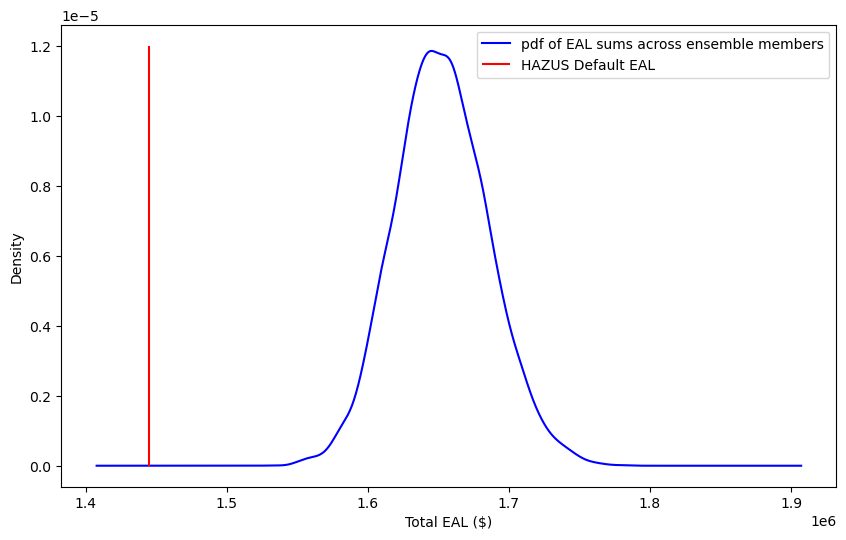

In [306]:
# Plot of the pdf of summed EAL within each SOW against the
# single value from default method
ens_sums = ens_df.groupby(['sow_ind'])['eal'].sum()
fig, ax = plt.subplots(figsize=(10, 6))
ens_sums.plot(kind='kde', ax=ax, color='blue', label='pdf of EAL sums across ensemble members')
ax.vlines(default_df['eal'].sum(), 0, 1.2e-5, color='red', label='HAZUS Default EAL')
ax.set_xlabel('Total EAL ($)')
ax.legend(loc='upper right')

In [307]:
ens_sums.describe()

count    1.000000e+04
mean     1.652305e+06
std      3.315996e+04
min      1.532533e+06
25%      1.629781e+06
50%      1.651367e+06
75%      1.674233e+06
max      1.782314e+06
Name: eal, dtype: float64

In [236]:
# Plot of the pdf of EAL across SOWs for a single property against
# its single value from the default method
# Do it for the property with the largest variance across SOWs
# "" median variance
# "" min variance
# Helps us get some sense of how variable these things are
# It could also be nice for these to do it in terms of rel_dam
# distribution in one panel and eal distribution in the other

In [ ]:
# Could be interesting to calculate the distribution of "distances"
# between default losses and the mean, default losses and the 95%-ile
# etc. 